## Процесс создания модели

Импортируем необходимые библиотеки. Для работы нам потрбуется, в основном библиотеки pandas и sklearn. Если какая-либо
библиотека отсутствует или не установлена на рабочей машине, её можно установить, набрав команду pip install lib_name в командной строке.

In [39]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression as log_reg, LinearRegression as lr_reg
from sklearn.ensemble import RandomForestClassifier as rf, RandomForestRegressor as rf_reg
from sklearn.ensemble import GradientBoostingClassifier as gb, GradientBoostingRegressor as gb_reg

import sklearn.cluster as cluster
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import time
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

### Загрузим данные для работы.

Датасет с инфоромацией по различным фруктам и их параметрам.

In [2]:
fruits = pd.read_csv('datasets/fruit_data_with_colors.txt', sep='\t')
fruits.drop('fruit_subtype', axis=1, inplace=True)
fruits.head()

,fruit_label,fruit_name,mass,width,height,color_score
0,1,apple,192,8.4,7.3,0.55
1,1,apple,180,8.0,6.8,0.59
2,1,apple,176,7.4,7.2,0.60
3,2,mandarin,86,6.2,4.7,0.80
4,2,mandarin,84,6.0,4.6,0.79


In [3]:
# Проверяем уникальные значения
fruits.fruit_name.unique()

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

In [4]:
# Получаем размер датасета
fruits.shape

(59, 6)

In [5]:
# Проверяем датасет на наличие пропущенных данных
fruits.isnull().values.any()

False

Посмотрим описательную статистику данных (среднее, стандартное отклонение, мин/макс значений и квартили). Данная операция легко выполняется с испльзованием функции pandas describe(). По значением среднего, мин/макса и отклонения, сразу видно, что переменные имеют раличные шкалы - к примеру шкала переменной mass значительно отличается от шкалы других переменных.
Поэтому в дальнейшем мы должны провести шкалирование данных (стандартизацию) для того, чтобы привести их к единой шкале. Это позволит нашей модели работать более чтоно. Если этого не делать, то переменная с большой шкалой будет иметь больший вес а модели, ухудшая её качество.

In [6]:
fruits.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


Подготовим даггын к разработкн модели классификации - выделим признаковое множество X и целевую переменную y. В данном случае мы будем предсказывать лейбл фруктов.

In [7]:
X = fruits[['mass', 'width', 'height', 'color_score']]
y = fruits['fruit_label']

<IPython.core.display.Javascript object>


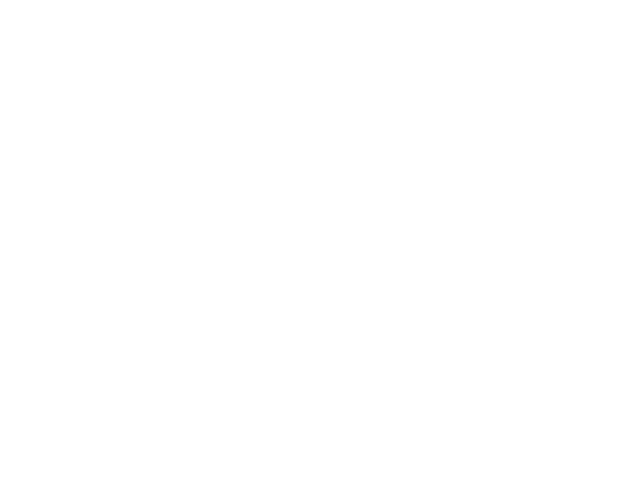

<AxesSubplot:>

In [8]:
corr = X.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Построим scatter plot для дальнейшего анализа даннх. Результаты построения показывают сильную зависимость переменной mass и width, ранее подтвержденную в ходе проведения корреляционного анализа. Так же мы можем заметить, что хоть данные не имеют
нормального распределения, однако распределение достаточно близко к нормальному. Поэтому вам не нужно будет осуществлять по типу log трансформации для привода данных в нормальное распределение для улучшения работы модели и мы можем ограничиться только шкалированием переменых.

<IPython.core.display.Javascript object>


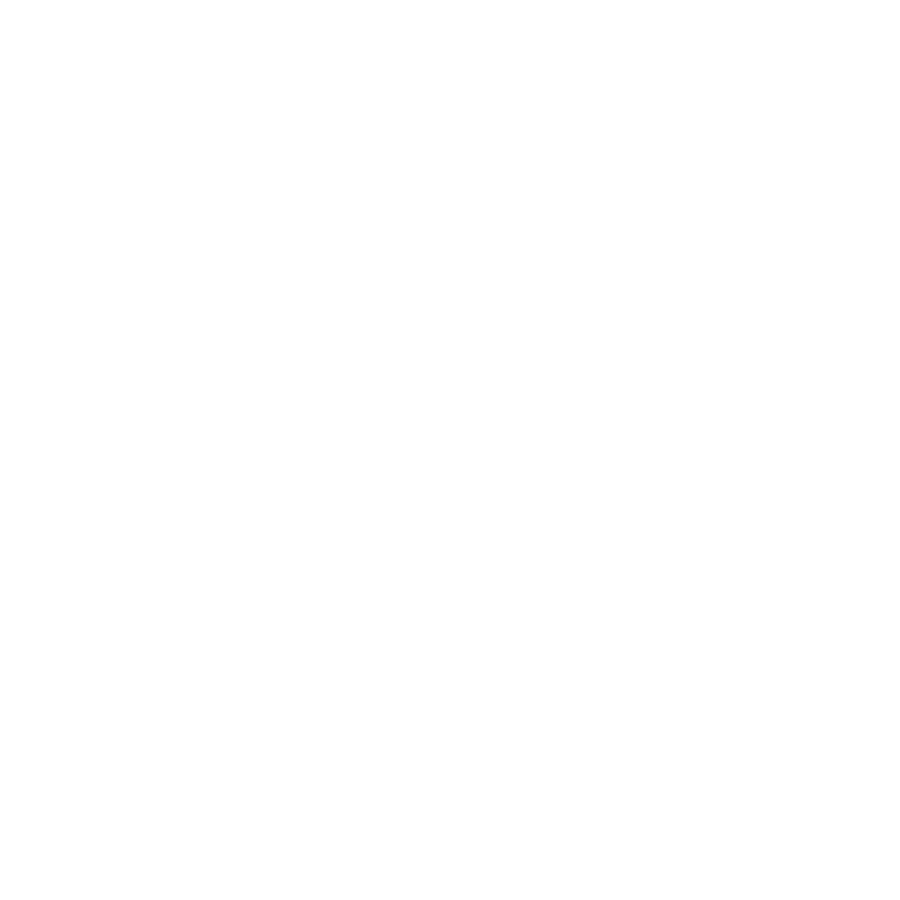

In [9]:
cmap = plt.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s = 40, hist_kwds={'bins':15}, figsize=(9, 9), cmap=cmap)

Проведем кроссвалидацию данных, для того, чтобы изюежать переобучения модели. Используем подход KFold с n_folds=10, который является основным для данной процедуры. Его идея состоит в том, что тренировка модели происходит на k-1 выборках (фолдах), а
валидация на оставщемся фолде. Создадим функцию cv() в которой будет осуществляться процесс кросс-валидации. Данная функция будет принимать на вход признаковое множество X, целевую переменную y и выбранный алгоритм.

In [10]:
def cv(X, y, clf_class):
    kf = KFold(n_splits=10, shuffle=False)
    
    y_pred = y.copy()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class()
        clf.fit(X_train, y_train)
        
        y_pred[test_index] = clf.predict(X_test)
        
    return y_pred

In [11]:
X = StandardScaler().fit_transform(X)

In [12]:
print(accuracy_score(y, cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.3898305084745763
0.41777557031794327
0.46234340456890194
0.3898305084745763


In [13]:
print(accuracy_score(y, cv(X, y, rf)))
print(f1_score(y, cv(X, y, rf),average='weighted'))
print(precision_score(y, cv(X, y, rf),average='weighted'))
print(recall_score(y, cv(X, y, rf),average='weighted'))

0.8305084745762712
0.8086286594761172
0.8304563233376794
0.8305084745762712


In [14]:
print(accuracy_score(y, cv(X, y, gb)))
print(f1_score(y, cv(X, y, gb),average='weighted'))
print(precision_score(y, cv(X, y, gb),average='weighted'))
print(recall_score(y, cv(X, y, gb),average='weighted'))

0.7796610169491526
0.7724346340822494
0.7826876513317191
0.7796610169491526


In [15]:
def cv(X, y, clf_class):
    kf = KFold(n_splits=10, shuffle=False)
    y_pred = y.copy()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class()
        clf.fit(X_train, y_train)
        
        penalty = ['l1', 'l2']
        C = np.logspace(0, 4, 10)
        hyperparameters = dict(C=C, penalty=penalty)
        
        clf = GridSearchCV(clf, hyperparameters, cv=10, verbose=0)
        best_model = clf.fit(X_train, y_train)
        
        y_pred[test_index] = best_model.predict(X_test)
    
    return y_pred

In [16]:
print(accuracy_score(y, cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.5932203389830508
0.5959096223001595
0.6013323665367535
0.5932203389830508


Так же данные для модели можно готовить не применяя валидационный сет, а просто деля выборку случайным образом на
тренировочный и тестовый сеты (к примеру, с помощью метода train_test_split()). Однако, данный подход вреват тем, что
модельможет переобучиться и показать неопределенно завышенные результаты, которые являются следствием непрравильной 
тренировки модели. Это отчетливо можно увидеть при построении learning_curve и оценке графика. Желательно во всех случаях
стараться использовать кросс-валидацию, к примеру KFold.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=0)

In [18]:
logistic_regression = log_reg()

In [19]:
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [20]:
y_pred = logistic_regression.predict(X_test)

In [21]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.6
0.5422969187675071
0.8166666666666668
0.6


In [22]:
random_forest = rf()

In [23]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
y_pred = random_forest.predict(X_test)

In [25]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.95
0.9522556390977442
0.9625
0.95


In [26]:
grad_boost = gb()

In [27]:
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier()

In [28]:
y_pred = grad_boost.predict(X_test)

In [29]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.85
0.8617647058823529
0.925
0.85


In [30]:
X = fruits[['fruit_label', 'width', 'height', 'color_score']]
y = fruits['mass']

In [31]:
X = StandardScaler().fit_transform(X)

Для оценки качества регрессионной модели, основными являютсяследующие метрики: среднеквадратичная ошибка, средняя
абсолютная ошибка и коэффициент  детерминации (r2_score).

In [48]:
print(mean_squared_error(y,cv(X,y,lr_reg)))
print(mean_absolute_error(y,cv(X,y,lr_reg)))
print(r2_score(y,cv(X,y,lr_reg)))

ValueError: Invalid parameter C for estimator LinearRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [41]:
print(mean_squared_error(y,cv(X,y,rf_reg)))
print(mean_absolute_error(y,cv(X,y,rf_reg)))
print(r2_score(y,cv(X,y,rf_reg)))

ValueError: Invalid parameter C for estimator RandomForestRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [42]:
print(mean_squared_error(y,cv(X,y,gb_reg)))
print(mean_absolute_error(y,cv(X,y,gb_reg)))
print(r2_score(y,cv(X,y,gb_reg)))

ValueError: Invalid parameter C for estimator GradientBoostingRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20,random_state = 0)

In [44]:
lin_regression = lr_reg()

In [45]:
lin_regression.fit(X_train, y_train)

LinearRegression()

In [46]:
y_pred = lin_regression.predict(X_test)

In [47]:
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

607.8043995486253
20.698509084377864
0.7980823612204583


In [50]:
grad_boost_reg = gb_reg()

In [51]:
grad_boost_reg.fit(X_train, y_train)

GradientBoostingRegressor()

In [53]:
y_pred = grad_boost_reg.predict(X_test)

In [56]:
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

150.76116649200824
9.092545976212197
0.9499158960015387


In [57]:
np.array(y_test)

array([362, 150, 194, 140, 172, 176, 142, 216, 154, 140,  84, 166, 158,
       180, 190, 154, 174,  76, 152, 164], dtype=int64)

In [58]:
y_pred

array([355.75832577, 163.06033759, 189.61706898, 140.62555007,
       175.75444438, 158.80160681, 167.92854308, 197.40601516,
       158.43981312, 158.90675443,  85.14363027, 169.62980002,
       158.86327277, 197.24313461, 190.33128506, 156.33914645,
       199.50221359,  80.5767521 , 156.82736626, 155.73810756])

In [59]:
fruits.columns

Index(['fruit_label', 'fruit_name', 'mass', 'width', 'height', 'color_score'], dtype='object')

In [61]:
X = fruits[['mass', 'width', 'height', 'color_score']]
X = StandardScaler().fit_transform(X)

Подготовим функцию plot_clusters(), которая принимает на вход признаковое множество X, выбранный алгоритм кластеризации и
расчитывает кластерык данным и отражает их на графике. Используем алгоритмы K-Means и Agglomerative Clustering.

In [99]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title(f'Алгоритм {algorithm.__name__}', fontsize=24)
    plt.text(-.5, .7, f'Время {end_time - start_time}', fontsize=14)

<IPython.core.display.Javascript object>


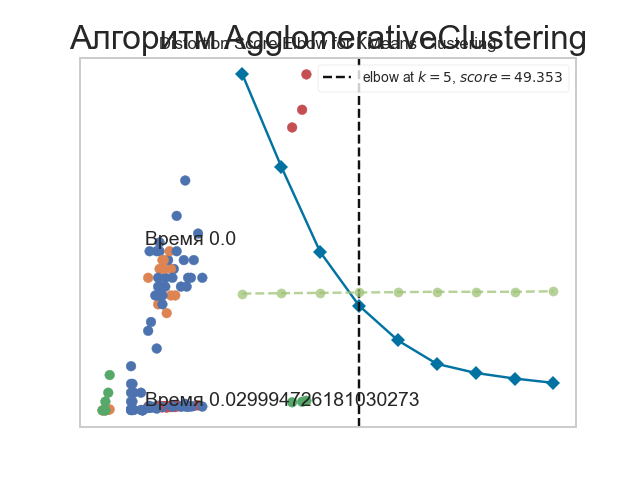

In [100]:
plot_clusters(X, cluster.KMeans, (), {'n_clusters':4})

Основные метрики оценки кластеризации - это distorsion_score и silhoette_score. Выбор количества кластеров осуществляется исходя из резкого изменения поведения функции на графике (в нашем примере, такое происходит при четырех кластерах). 

In [101]:
model = KElbowVisualizer(cluster.KMeans(), metric='distortion', k=10)
model.fit(X)
model.poof()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
plot_clusters(X, cluster.AgglomerativeClustering, (), {'n_clusters':4, 'linkage':'ward'})

In [103]:
kmeans = cluster.KMeans(n_clusters=4, random_state=0).fit(X)

In [106]:
model = kmeans.labels_
model

array([0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 0, 1, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 1, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [107]:
fruits['КМ'] = pd.Series(model, index=fruits.index)

In [108]:
fruits

,fruit_label,fruit_name,mass,width,height,color_score,КМ
0,1,apple,192,8.4,7.3,0.55,0
1,1,apple,180,8.0,6.8,0.59,0
2,1,apple,176,7.4,7.2,0.60,0
3,2,mandarin,86,6.2,4.7,0.80,1
4,2,mandarin,84,6.0,4.6,0.79,1
5,2,mandarin,80,5.8,4.3,0.77,1
6,2,mandarin,80,5.9,4.3,0.81,1
7,2,mandarin,76,5.8,4.0,0.81,1
8,1,apple,178,7.1,7.8,0.92,3
9,1,apple,172,7.4,7.0,0.89,3
